In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
palette_hc = ['#ffffff', '#ddaa33', '#bb5566', '#004488', '#000000']

from tqdm.auto import tqdm

import time
import os
from collections import OrderedDict
import json
import pickle

import gc

import sys
sys.path.append("../")

from src.helpers import calculate_RMSE_balanced, Timer, autoscaling, \
                        calculate_composite_RMSE_V_CaT, update_array_from_kwargs, get_value_by_key

In [3]:
def collect_genes_dict(config):

    genes_dict = {ec_name:
                  {p_name: dict(bounds = p['bounds'],
                                gamma  = p['gamma' ],
                                is_multiplier = p.get("is_multiplier", False))
                   for p_name, p in ec['params'].items() if isinstance(p, dict)}
                  for ec_name, ec in config['experimental_conditions'].items()}
    
    return OrderedDict(genes_dict)


def collect_constants_dict(config):

    constants_dict = {ec_name: {p_name: value for p_name, value in ec['params'].items() if isinstance(value, (int, float))}
                      for ec_name, ec in config['experimental_conditions'].items()}
    
    return OrderedDict(constants_dict)

In [3]:
idx = pd.IndexSlice

In [7]:
case_list = 'G3/C3/201209_190317', #'G2/C4/201209_090417', #'G2/C4/201209_051008', #'G1/C3/201209_000428', 'G1/C3/201209_000344'

config_list = []
sol_list = []
columns_sol = []
tag_list = []

genes_all = {}

for case in tqdm(case_list):
    
    group, cell, suffix = case.split('/')
    group, cell = int(group[-1]), int(cell[-1])

    dirname_results = "cases/koivumaki/results/voigt"
    cf = os.path.join(dirname_results, case, "config_backup.pickle")

    config_path = os.path.dirname(os.path.realpath(cf))

    with open(cf, 'rb') as f:
        config = pickle.load(f)

    config_list.append(config)

    #print(config['runtime']['output_folder_name'])
    
    dirname_report = os.path.join("images/koivumaki/reports/", case)
    os.makedirs(dirname_report, exist_ok=True)

    # dict + dict
    try:
        genes = config['runtime']['genes_dict']
    except:
        genes = collect_genes_dict(config)

    genes_all = {**genes_all, **genes}

    n_genes = sum(map(len, genes.values()))  

    dump = np.fromfile(os.path.join(config_path, "dump.bin"),
                       #dtype=np.half,
                       )
    dump = dump.reshape(-1, n_genes + 1)
    dump = np.roll(dump, axis=1, shift=1)

    try:
        n_organisms = config['runtime']['n_organisms']
    except:
        n_organisms = config['n_organisms']

    n_epochs = len(dump) // n_organisms

    columns_tuples = [('common', 'fitness')] + [(item[0], key) for item in genes.items() for key in item[1]]
    m_index_columns = pd.MultiIndex.from_tuples(columns_tuples)

    index_tuples = [(epoch, org) for epoch in range(n_epochs) for org in range(n_organisms)]
    m_index_index = pd.MultiIndex.from_tuples(index_tuples)

    dump = pd.DataFrame(dump, index=m_index_index, columns=m_index_columns)

    sol_list.append([(group, cell, suffix), genes, dump.loc[n_epochs-1, 0].values[1:]])

In [8]:
columns_tuples = [(item[0], key) for item in genes_all.items() for key in item[1]]
m_index = pd.MultiIndex.from_tuples(columns_tuples)

index_tuples = [x[0] for x in sol_list]
m_index_index = pd.MultiIndex.from_tuples(index_tuples)

df_sol = pd.DataFrame([[None for item in columns_tuples]] * len(sol_list),
                      columns=m_index, index=m_index_index)

for i, (case_index, genes, values) in enumerate(sol_list):
    columns_i = [(item[0], key) for item in genes.items() for key in item[1]]
    for j, c in enumerate(columns_i):
        df_sol.loc[case_index, c] = values[j]

In [9]:
df_sol

common                                                \
                      PNa     gCaL        gt     gKur      gK1      gKr   
3 3 201209_190317  1.7423  3.40176  0.113815  9.87457  5.35305  1.12946   

                                                         ...     2064  \
                        gKs      gNab     gCab  INaKmax  ...      Nai   
3 3 201209_190317  0.119649  0.561736  8.75155  9.96473  ...  5.42925   

                               1032               516               344  \
                        Ki      Nai       Ki      Nai       Ki      Nai   
3 3 201209_190317  149.393  5.21576  148.255  5.74305  139.488  6.30065   

                                258           
                        Ki      Nai       Ki  
3 3 201209_190317  142.206  6.81438  139.875  

[1 rows x 27 columns]

In [10]:
#c_list = (1, 3, '201209_000428'),
#for c in c_list:
    
df = df_sol.iloc[0]

print(df['common'], '\n - - - - - ')
print(df_sol.loc[:, idx[:, ['Nai', 'Ki']]].stack())

PNa                         1.7423
gCaL                       3.40176
gt                        0.113815
gKur                       9.87457
gK1                        5.35305
gKr                        1.12946
gKs                       0.119649
gNab                      0.561736
gCab                       8.75155
INaKmax                    9.96473
ICaPmax                    8.40101
gIf                       0.136613
kNaCa                      9.86717
Jrel_multiplier            0.10567
J_SERCASR_multiplier      0.166838
J_bulkSERCA_multiplier     9.99747
kSRleak                    4.35744
Name: (3, 3, 201209_190317), dtype: object 
 - - - - - 
                          1032     2064      258      344      516
3 3 201209_190317 Ki   148.255  149.393  139.875  142.206  139.488
                  Nai  5.21576  5.42925  6.81438  6.30065  5.74305


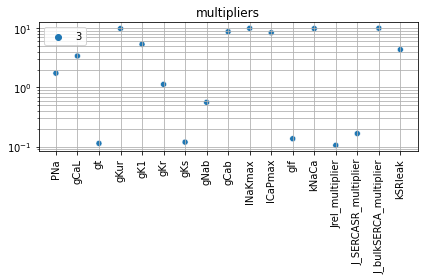

In [11]:
sns.scatterplot(data=df_sol['common'].T)
plt.setp(plt.gca().get_xticklabels(), rotation=90)
plt.yscale('log')
plt.grid(which='both')
plt.title('multipliers')

plt.tight_layout()

#plt.savefig("./images/koivumaki/reports/Fri_Dec_4_mults.png", dpi=300)

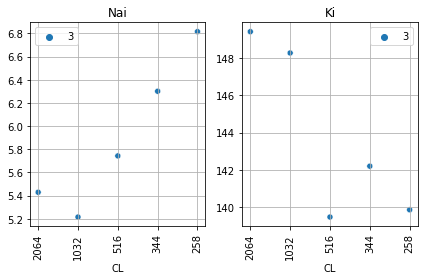

In [12]:
fig, axes = plt.subplots(ncols=2)

for i, item in enumerate(['Nai', 'Ki']):
    plt.sca(axes[i])
    df = df_sol.loc[:, idx[:, item]].T.unstack().copy()
    df.index = df.index.astype('str')
    sns.scatterplot(data=df)
    plt.setp(plt.gca().get_xticklabels(), rotation=90)
    plt.grid()
    plt.title(item)
    plt.xlabel('CL')
    
plt.tight_layout()

#plt.savefig("./images/koivumaki/reports/Fri_Dec_4_params.png", dpi=300)

In [13]:
phenotype_model = {}
phenotype_model_last = {}
gc.collect()


for exp_cond_name in tqdm(config['experimental_conditions']):
    
    if exp_cond_name == 'common':
        continue
    
    if True:
        index_col = ['epoch', 'index']
        usecols = index_col + ['V',
                               'Cai1', 'Cai2', 'Cai3', 'Cai4', 'Cass',
                               'Nai', 'Ki'] 

        filename = os.path.join(config_path, "phenotype", f"phenotype_{exp_cond_name}.csv")
        if os.path.isfile(filename):
            try:
                phenotype_model_last[exp_cond_name] = pd.read_csv(filename,
                                                                  #usecols=usecols
                                                                 )
                phen_len = len(phenotype_model_last[exp_cond_name])
            except pd.errors.EmptyDataError as e:
                print(f'{filename} is empty')
                continue

    
            if False:
                filename = os.path.join(config_path, "phenotype", f"phenotype_{exp_cond_name}.bin")    
                phenotype_model[exp_cond_name] = np.fromfile(filename, dtype=np.float32).reshape(-1, len(config['runtime']['states_initial']))

                n_epochs = len(phenotype_model[exp_cond_name]) // phen_len

                m_index_tuples = [(epoch, index) for epoch in range(n_epochs) for index in range(phen_len)]
                m_index = pd.MultiIndex.from_tuples(m_index_tuples)

                phenotype_model[exp_cond_name] = pd.DataFrame(phenotype_model[exp_cond_name],
                                                              index=m_index,
                                                              columns=phenotype_model_last[exp_cond_name].columns)

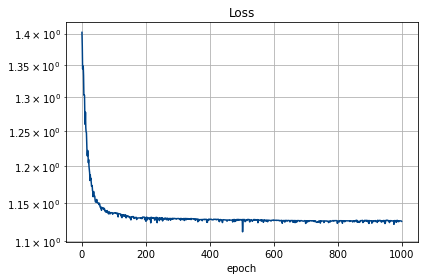

In [14]:
plt.semilogy(-dump['common', 'fitness'].loc[idx[:, 0]], color=palette_hc[-2])
plt.grid(which='both')
plt.title('Loss')
plt.xlabel('epoch')
plt.tight_layout()
# plt.savefig("./images/koivumaki/loss.png", dpi=600)

In [15]:
#dump.columns.levels

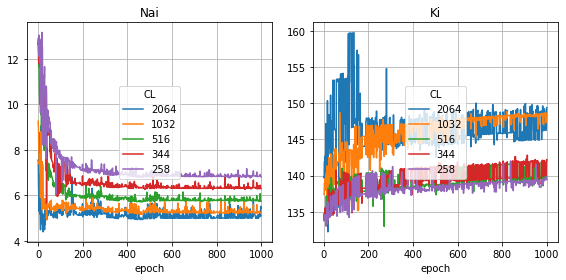

In [16]:
items = ['Nai', 'Ki']


nrows = 1
ncols = len(items)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         figsize=plt.figaspect(nrows / ncols),
                         #sharex='col', sharey='row',
                        )

for i, item in enumerate(items):
    plt.sca(axes[i])
    for column in dump:
        if item not in column:
            continue
        #max_epoch = dump.index[-1][0]
        #x_space = np.linspace(0, max_epoch, len(dump))
        plt.plot(dump.loc[idx[:, 0], column].values, label=column[0])
    plt.legend(title='CL', loc='center')
    plt.xlabel('epoch')
    plt.grid()
    plt.title(item)

dirname = os.path.join("./images/koivumaki/reports/", case,)
os.makedirs(dirname, exist_ok=True)                

plt.tight_layout()
plt.savefig(os.path.join(dirname, "concentrations.png"), dpi=600)

In [360]:
%matplotlib

Using matplotlib backend: Qt5Agg


CL = 2064, rmse_V = 6.943e-02
CL = 1032, rmse_V = 3.655e-02
CL = 516, rmse_V = 7.510e-02
CL = 344, rmse_V = 5.884e-02
CL = 258, rmse_V = 1.007e-01
CL = 2064, rmse_CaT = 1.637e-01
CL = 1032, rmse_CaT = 1.600e-01
CL = 516, rmse_CaT = 2.157e-01
CL = 344, rmse_CaT = 2.543e-01
CL = 258, rmse_CaT = 2.829e-01


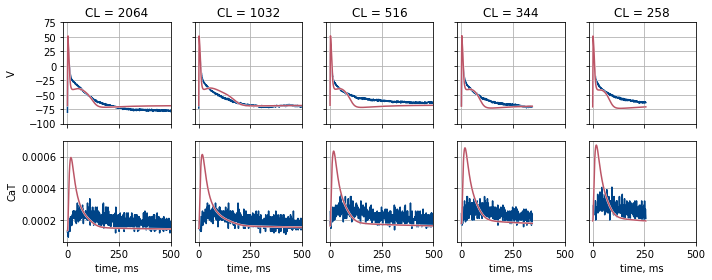

In [17]:
items = ['V', 'CaT']
exp_cond_dict = [item for item in config['experimental_conditions'].items() if item[0] != 'common']


nrows = len(items)
ncols = len(exp_cond_dict)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                         figsize=plt.figaspect(nrows / ncols),
                         sharex='col', sharey='row')

for i_item, item in enumerate(items):
    for i_cond, (exp_cond_name, exp_cond) in enumerate(exp_cond_dict):
        
        ax = axes[i_item, i_cond]

        if item == 'V':
            exp = exp_cond['phenotype'][:, 0]
            model = phenotype_model_last[exp_cond_name]['V'].values[:len(exp)]
            
            rmse = calculate_RMSE_balanced(exp, model)
            
            ax.set_yticks(np.arange(-100, 75 + 1, 25))
            ax.set_ylim(-100, 75)

        elif item == 'CaT':
            exp = exp_cond['phenotype'][:, 1]
            model = phenotype_model_last[exp_cond_name].loc[:, 'Cai1': 'Cass'].values.mean(axis=1)[:len(exp)]
            rmse = calculate_RMSE_balanced(exp, model)

#             model_rescaled = (model - model.min()) / model.ptp()
#             exp_rescaled, rmse, _ = autoscaling(exp, model_rescaled[:len(exp)])
#             exp, _, _ = autoscaling(exp, model[:len(exp)])

            #ax.set_yticks(np.arange(0, 1.6e-3, 0.5e-3))
            #ax.set_ylim(0, 1.5e-3)
            
        print(f"CL = {exp_cond_name}, rmse_{item} = {rmse:.3e}")
        
        if i_cond == 0:
            ax.set_ylabel(item)

        ax.plot(exp, color='w', lw=2)
        ax.plot(exp, color=palette_hc[3], lw=1.5)

        ax.plot(model, color='w', lw=2)
        ax.plot(model, color=palette_hc[2], lw=1.5)
                
        ax.grid()
        
        if i_item == 0:
            ax.set_title(f'CL = {exp_cond_name}')
        else:
            ax.set_xlabel('time, ms')
            ax.set_xticks(np.arange(0, 750+1, 250))
            ax.set_xlim(-20, 500)

              
dirname = os.path.join("./images/koivumaki/reports/", case,)
os.makedirs(dirname, exist_ok=True)                

fig.align_labels()
plt.tight_layout()
plt.savefig(os.path.join(dirname, "waveforms.png"), dpi=600)

SystemError: <built-in method write of _io.BufferedWriter object at 0x7f1bd2e22290> returned a result with an error set

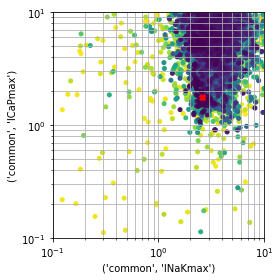

In [25]:
plt.figure(figsize=plt.figaspect(1))

name_x, name_y = ('common', 'INaKmax'), ('common', 'ICaPmax')
#name_x, name_y = ('2064', 'Ki'), ('common', 'gCaL')

epoch = 0

df = dump.loc[epoch][::-1]
#c = np.arange(len(df)) # np.log(-df['common', 'fitness'])

scat = plt.scatter(df[name_x], df[name_y], c=df.index, s=16)
line_best, = plt.plot(df[name_x].loc[0],
                      df[name_y].loc[0], 'Xr')

if genes[name_x[0]][name_x[1]].get('is_multiplier', False):
    plt.xscale('log')
if genes[name_y[0]][name_y[1]].get('is_multiplier', False):
    plt.yscale('log')

plt.xlabel(name_x)
plt.ylabel(name_y)

plt.xlim(genes[name_x[0]][name_x[1]]['bounds'])
plt.ylim(genes[name_y[0]][name_y[1]]['bounds'])

plt.grid(which='both')
plt.tight_layout()
#plt.gcf().align_labels()

dirname = os.path.join("./images/koivumaki/reports/",case, 'pairplots', "_".join(name_x + name_y))
os.makedirs(dirname, exist_ok=True)

for epoch in tqdm(range(0, dump.index[-1][0])):
    df = dump.loc[epoch][::-1]
    #c = np.arange(len(df)) # np.log(-df['common', 'fitness'])
    scat.set_offsets(df[[name_x, name_y]])
    scat.set_array(df.index)
    line_best.set_data(df[name_x].loc[0], df[name_y].loc[0])
    plt.savefig(os.path.join(os.path.join(dirname, f"pairplot_{epoch:04d}.png")), dpi=200)

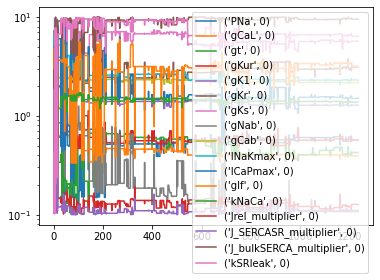

In [26]:
df = dump.loc[idx[:, 0], 'common'].unstack().iloc[:, 1:]

for key in df:
    plt.semilogy(df[key], label=key)
plt.legend()

In [27]:
l = []
for i in range(256):
    df = pd.read_csv(os.path.join(config_path, f"mpi/report_{i:04d}.csv")).iloc[1:]
    df['rank'] = i
    l.append(df)
    
df = pd.concat(l)
#df.set_index('rank', append=True, inplace=True)

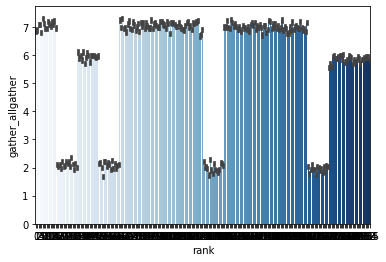

In [28]:
sns.barplot(y='gather_allgather', data=df, x='rank', palette="Blues")
#sns.barplot(y='calc', data=df, x='rank', palette="Reds")

# Prepare baselines

In [8]:
import numpy as np
import pandas as pd
import ctypes
import matplotlib.pyplot as plt

import time
import os


filename_so = '/home/andrey/WORK/Reentry/pypoptim/src/model_ctypes/_koivumaki/koivumaki.so'
filename_so_abs = os.path.abspath(filename_so)

model = ctypes.CDLL(filename_so_abs)

model.initialize_states_default.argtypes = [
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS')
]

model.initialize_states_default.restype = ctypes.c_void_p


model.initialize_constants_default.argtypes = [
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS')
]

model.initialize_constants_default.restype = ctypes.c_void_p


model.run.argtypes = [
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'),
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'),
    ctypes.c_int,
    ctypes.c_double,
    ctypes.c_double,
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=2, flags='C_CONTIGUOUS')#,
    #np.ctypeslib.ndpointer(dtype=np.float64, ndim=2, flags='C_CONTIGUOUS'),
    #np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS')
]

model.run.restype = ctypes.c_int

legend_constants = pd.read_csv("./src/model_ctypes/_koivumaki/legend_constants.csv")
legend_states = pd.read_csv("./src/model_ctypes/_koivumaki/legend_states.csv")

In [50]:
S = np.zeros(len(legend_states)) #  np.loadtxt("S.txt")
C = np.zeros(len(legend_constants)) #  np.loadtxt("C.txt")

model.initialize_states_default(S)
model.initialize_constants_default(C)

4607182418800017408

In [116]:
def create_C_S(organism, config, exp_cond_name):

    legend = config['runtime']['legend']
    genes_dict = config['runtime']['genes_dict']
    constants_dict = config['runtime']['constants_dict']

    genes_current = organism['genes'][['common', exp_cond_name]]
    constants_dict_current = {#constants_dict['common'],
                              **constants_dict[exp_cond_name],
                             }

    C = legend['constants'].copy()
    S = organism['state'][exp_cond_name].copy()

    for i in range(len(genes_current)):
        g_name = genes_current.index.get_level_values(1).to_list()[i]

        if g_name in legend['constants'].index:
            for ecn in ['common', exp_cond_name]:
                if g_name in genes_dict[ecn]:
                    if genes_dict[ecn][g_name]['is_multiplier']:
                        C[g_name] *= genes_current[ecn, g_name]
                    else:
                        C[g_name] = genes_current[ecn, g_name]

        if g_name in legend['states'].index:
            for ecn in ['common', exp_cond_name]:
                if g_name in genes_dict[ecn]:
                    if genes_dict[ecn][g_name]['is_multiplier']:
                        S[g_name] *= genes_current[ecn, g_name]
                    else:
                        S[g_name] = genes_current[ecn, g_name]

    for c_name, c in constants_dict_current.items():
        print(c_name, c)
        if c_name in legend['constants'].index:
            C[c_name] = c
        if c_name in legend['states'].index:
            S[c_name] = c

    return C, S

In [139]:
genes = dump.loc[(idx[:, 0]), :].iloc[-1]

state = pd.DataFrame({exp_cond_name: phenotype_model_last[exp_cond_name].iloc[-1]
         for exp_cond_name in config['experimental_conditions'] if exp_cond_name != 'common'})

C, S = create_C_S(dict(genes=genes, state=state), config, '258')

STIM_PERIOD 0.258


In [140]:
t_sampling = 0.001

stim_period = C['STIM_PERIOD']
#stim_period = get_value_by_key(C, legend_constants, 'STIM_PERIOD')
n_samples_per_stim = int(stim_period / t_sampling)

n_beats = 1000
tol = 1e-6

# chain_length = 50
# v_threshold = 1e-1
# t_safe = 1e-2

output = np.zeros((n_samples_per_stim * n_beats + 1, len(S)))
#output_A = np.zeros((n_samples_per_stim * n_beats + 1, 107))
#output_t = np.zeros((n_samples_per_stim * n_beats + 1))

In [141]:
#status = model.run(S.values.copy(), C.values.copy(), n_beats, t_sampling, tol, output)
status = model.run(S.values.copy(), C.values.copy(), n_beats, t_sampling, tol, output)

print(status)

2


In [142]:
output = pd.DataFrame(output, columns=legend_states['name'])

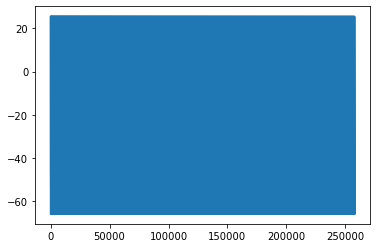

In [143]:
plt.plot(output.V)

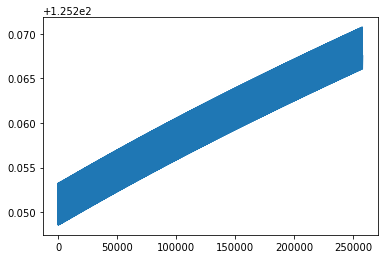

In [144]:
plt.plot(output.Ki)

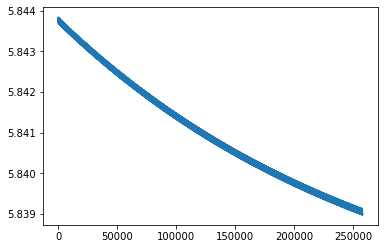

In [145]:
plt.plot(output.Nai)

In [146]:
err_abs = output.iloc[-1] - output.iloc[0]
err_rel = err_abs / output.iloc[0] * 100

In [147]:
items = ['Nai', 'Ki', 'V', 'Cass']
df_err= pd.DataFrame([err_rel[items], err_abs[items]],
                     index=['err_rel', 'err_abs'])
df_err

name,Nai,Ki,V,Cass
err_rel,-0.080748,0.013987,-0.023111,-3.399541e-02
err_abs,-0.004719,0.017519,0.015245,-1.262753e-07


In [383]:
with open("./cases/koivumaki/invalid.pickle", 'rb') as f:
    invalid = pickle.load(f)

In [384]:
invalid['genes']

ec_name  g_name                
common   PNa                         0.115469
         gCaL                        0.357668
         gt                          0.580297
         gKur                        4.419772
         gK1                         8.274927
         gKr                         1.502725
         gKs                         0.287927
         gNab                        4.446609
         gCab                        1.133524
         INaKmax                     0.473646
         ICaPmax                     1.363152
         gIf                         1.376925
         kNaCa                       7.980599
         Jrel_multiplier             0.266783
         J_SERCASR_multiplier        0.101856
         J_bulkSERCA_multiplier      0.120808
         kSRleak                     8.975239
2064     Nai                         7.855845
         Ki                        142.343470
1032     Nai                        16.340855
         Ki                        143.926869
51

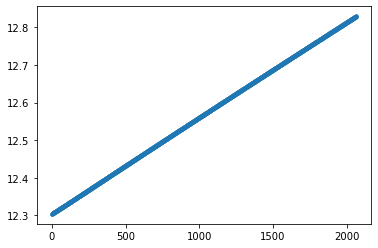

In [265]:
plt.plot(invalid['phenotype'][0]['Nai'], '.-')

In [73]:
np.max(np.diff(config['experimental_conditions'][1]['phenotype'][:, 0]))

67.138671875

In [74]:
np.max(np.diff(phenotype_model[1032]['V']))

109.55

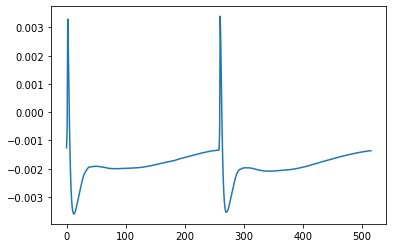

In [75]:
plt.plot(output[-2 * CL -1: -1, 23] - output[-3 * CL -1 : -1 * CL -1 :, 23])

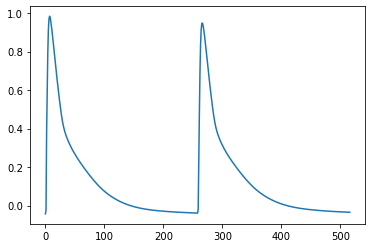

In [76]:
plt.plot(output[: 2 * CL + 1, 23] - output[-2 * CL - 1:, 23])

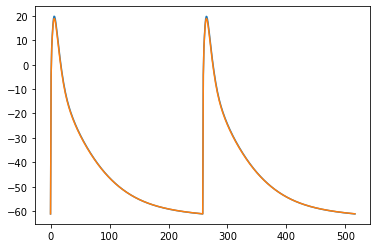

In [77]:
plt.plot(output[: 2 * CL + 1, 23])
plt.plot(output[-2 * CL - 1:, 23])

In [78]:
output = output[-CL - 1:]
print(output.shape)

(259, 43)


In [148]:
S = output[-1]
#np.savetxt(f"/home/andrey/WORK/Reentry/pypoptim/cases/koivumaki/v0/states/state_{CL}.txt", S)

In [150]:
V = output[:, 23]
Ca_i_mean = output.T[4: 9].mean(axis=0)
phenotype = np.vstack([V, Ca_i_mean]).T
#np.savetxt(f"/home/andrey/WORK/Reentry/pypoptim/cases/koivumaki/v0/baselines/V_Cai_mean_{CL}.txt", phenotype)

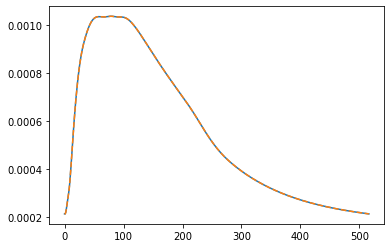

In [156]:
Ca_i_mean = output.T[4: 9].mean(axis=0)
Ca_i_sum  = output.T[4: 9].sum(axis=0)
plt.plot(Ca_i_mean)
plt.plot(Ca_i_sum / 5, '--')

In [165]:
for CL in [2000, 1500, 1000, 500, 333, 250, 200, 166]:
    phenotype = np.loadtxt(f"/home/andrey/WORK/Reentry/pypoptim/cases/koivumaki/v0/baselines/V_Cai_mean_{CL}.txt")
    np.savetxt(f"/home/andrey/WORK/Reentry/pypoptim/cases/koivumaki/v0/baselines/V_Cai_mean_{CL}.txt", phenotype.T)

In [158]:
len(phenotype)

2

In [163]:
a = np.loadtxt("./cases/maleckar/v0/baselines/V_Ca_i_1000.txt")

In [164]:
a.shape

(1000, 2)

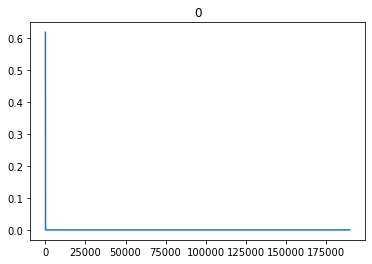

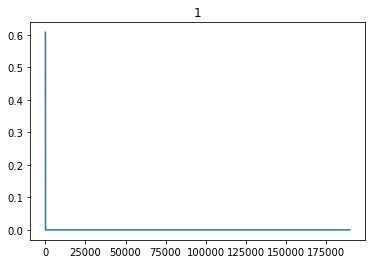

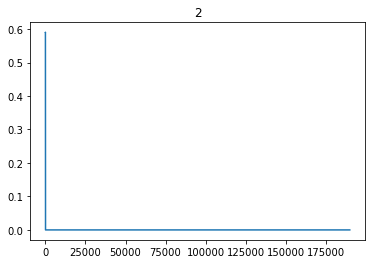

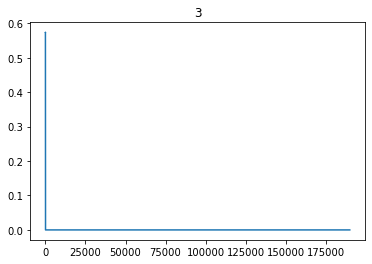

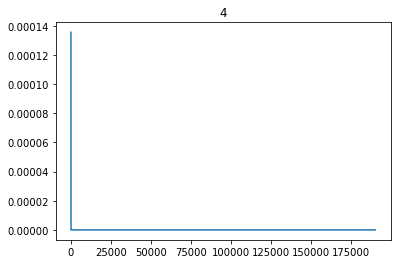

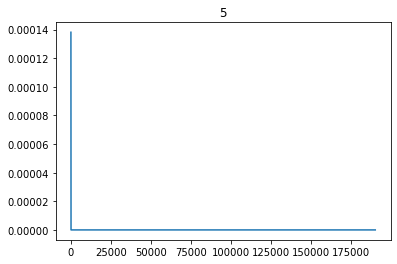

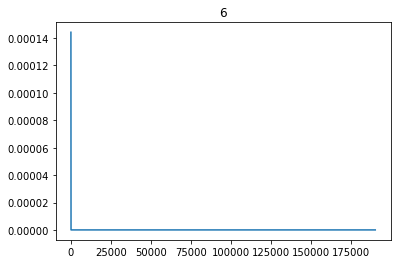

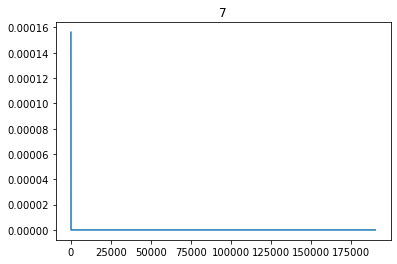

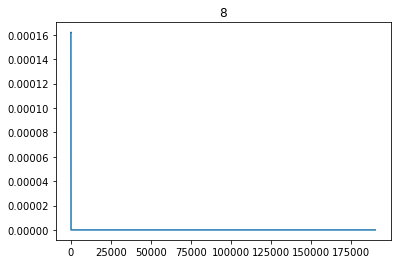

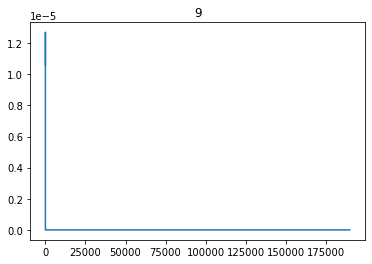

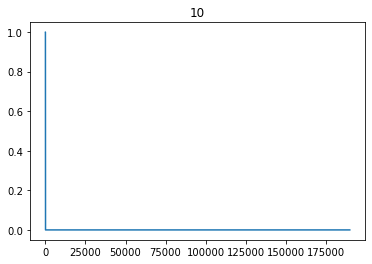

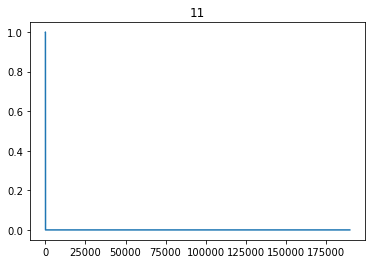

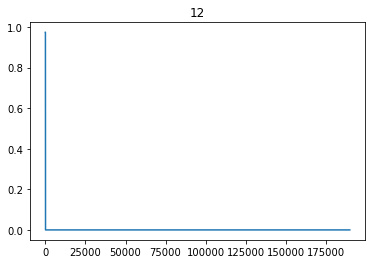

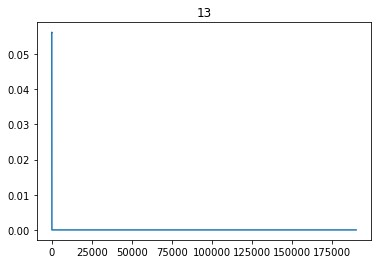

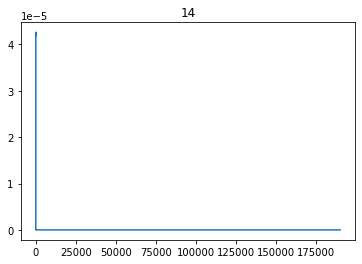

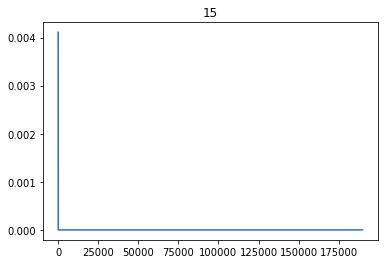

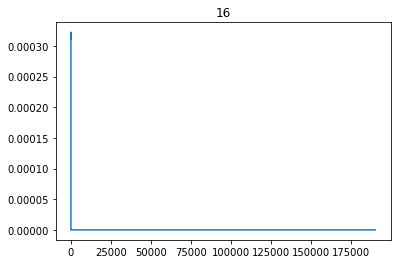

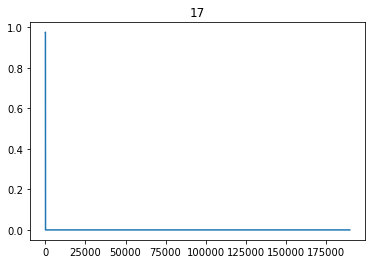

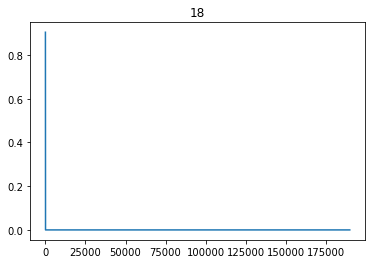

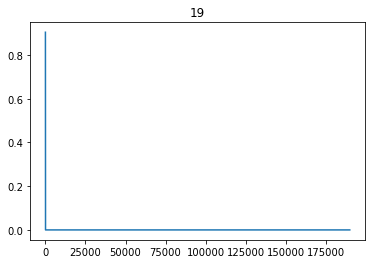

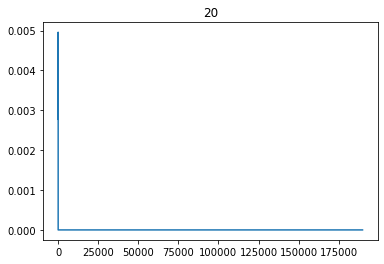

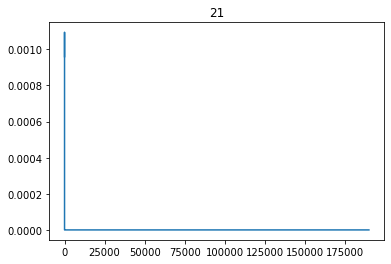

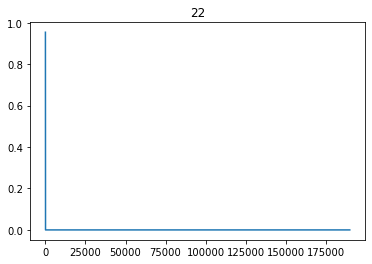

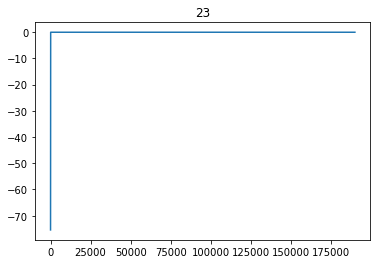

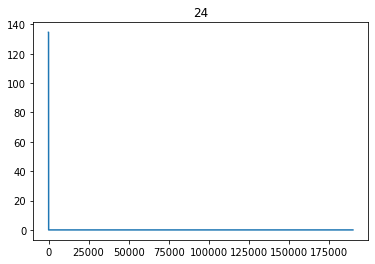

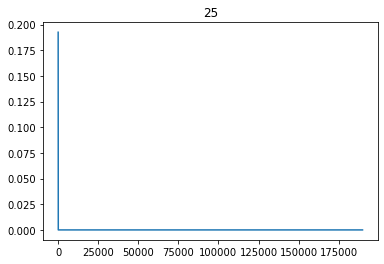

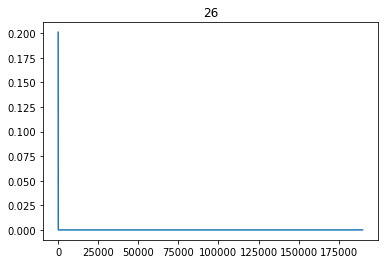

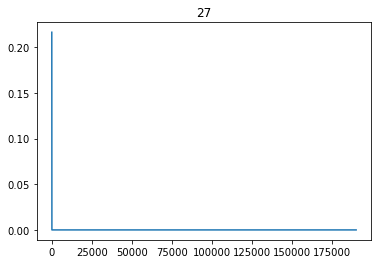

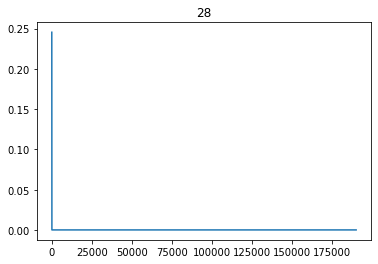

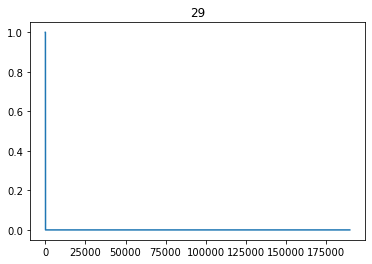

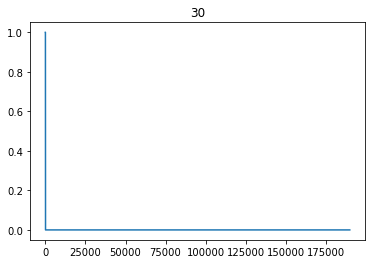

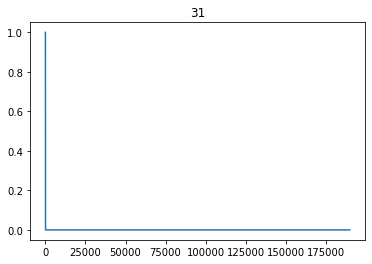

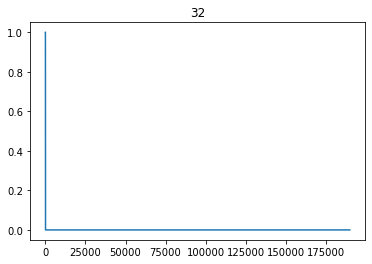

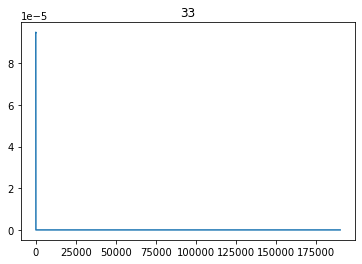

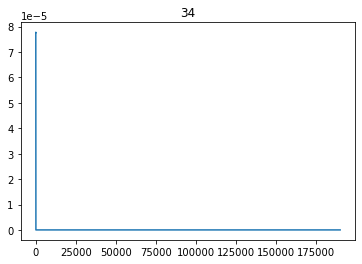

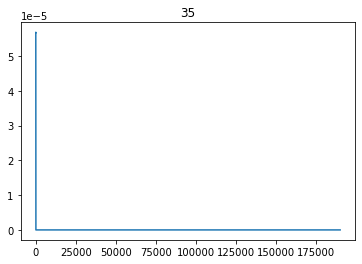

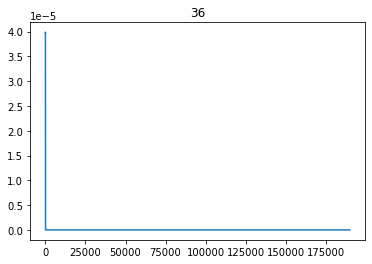

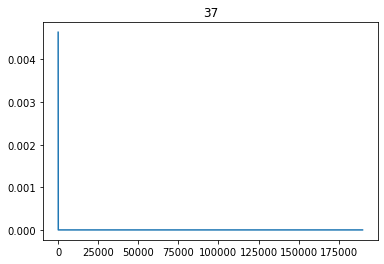

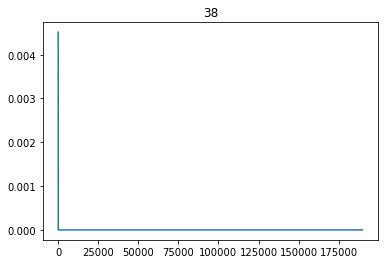

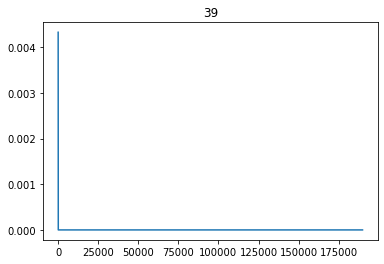

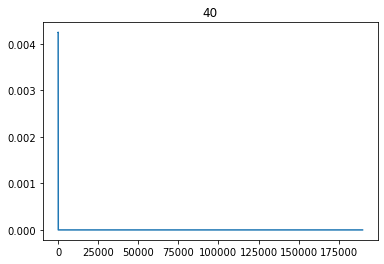

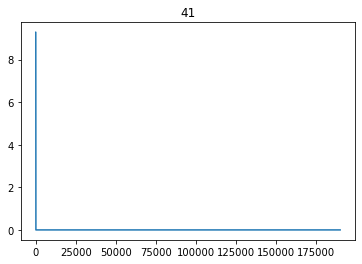

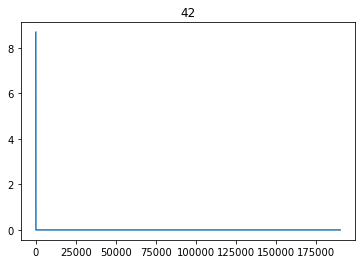

In [6]:
for i in range(output.shape[-1]):
    plt.title(str(i))
    plt.plot(output[:, i])
    plt.show()

# Voigt

71.71630859375


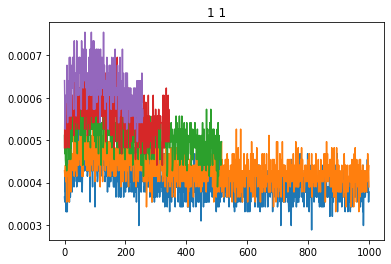

74.462890625


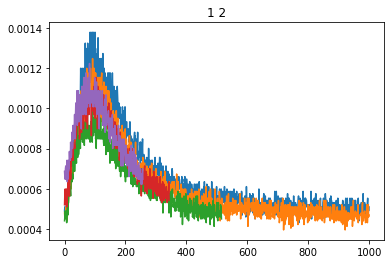

67.138671875


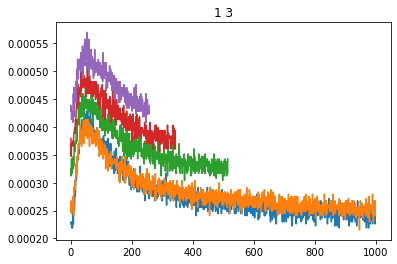

57.67822265625


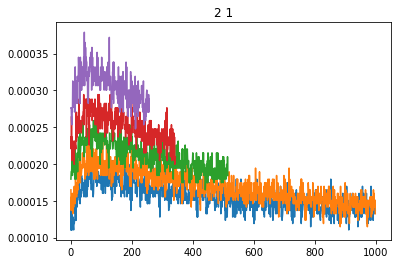

65.00244140625


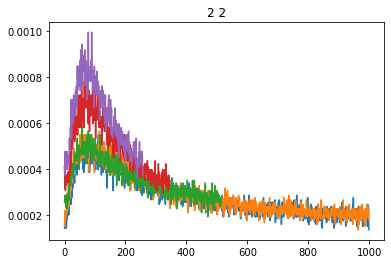

95.21484375


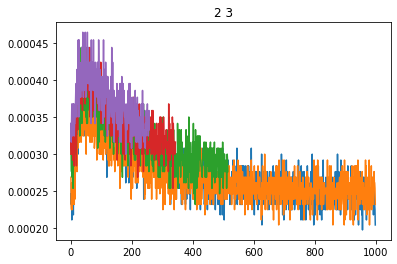

76.59912109375


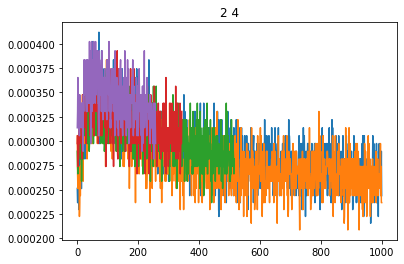

81.48193359375


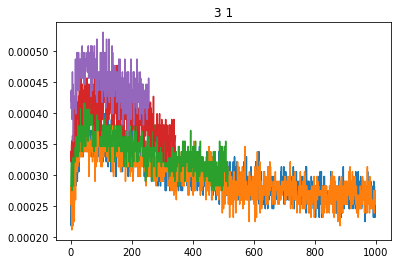

88.5009765625


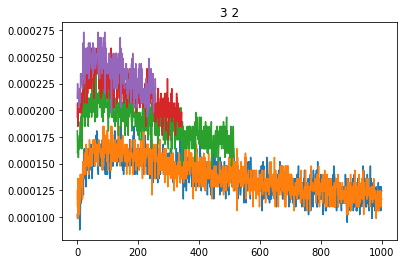

59.2041015625


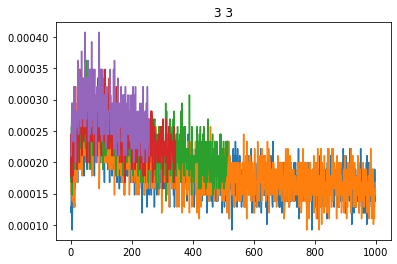

133.36181640625


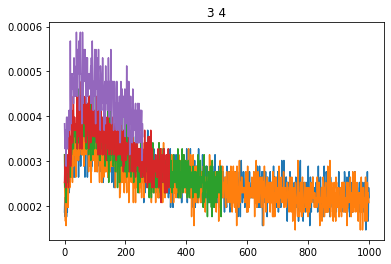

87.58544921875


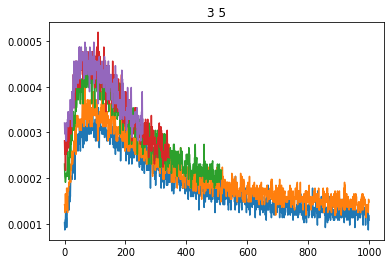

86.669921875


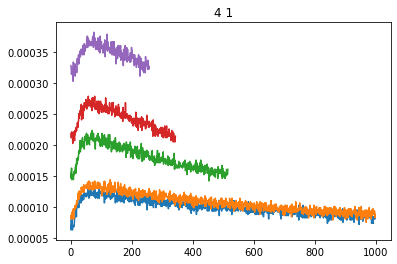

107.421875


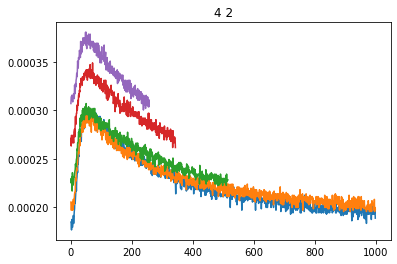

66.5283203125


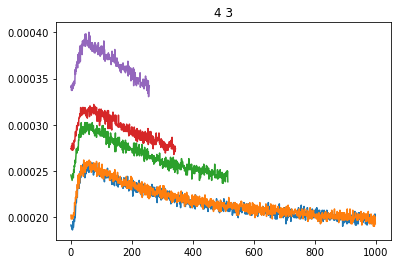

92.46826171875


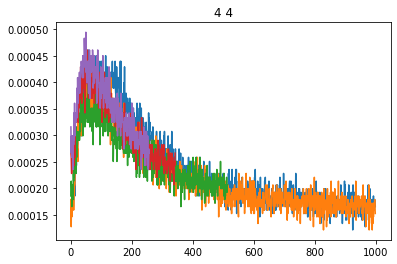

84.53369140625


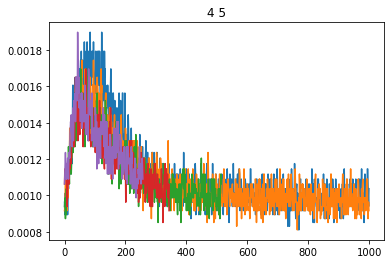

86.97509765625


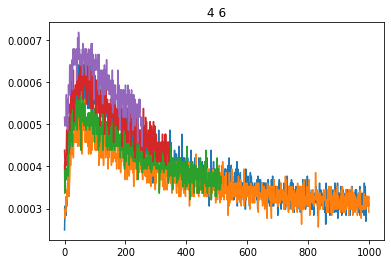

79.9560546875


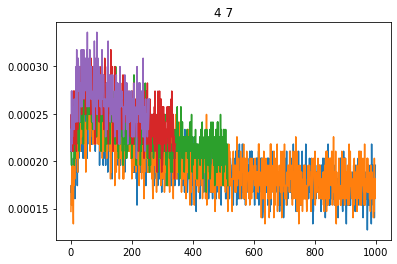

72.93701171875


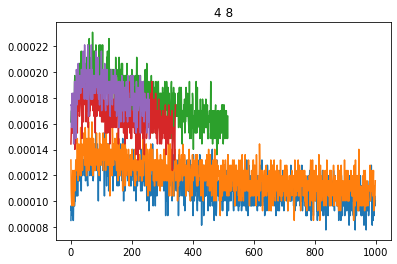

In [13]:
group_indices = range(1, 4 + 1)
cell_indices = [3, 4, 5, 8]

CL_list = [2064, 1032, 516, 344, 258]

df_CaT = pd.read_csv("/home/andrey/Dropbox/Voigt/voigt_CaT_params.csv")
df_CaT.set_index(['Group', 'Cell'], inplace=True)

dV_list = []

for ig in group_indices:
    for ic in range(1, cell_indices[ig-1] + 1):
        for CL in CL_list:
            sweep = np.loadtxt(f"../../Data/Voigt/Action_potentials_AG_Voigt/chosen_sweeps/{ig}_{ic}_{CL}.txt")
            phenotype = sweep[::10, [0, 2]]
                        
            FBL, Fmax = df_CaT.loc[(ig, ic), :]
            K = 864 / 1000. / 1000. # mM
            F = phenotype[:, 1]
            cat = K * (F - FBL) / (Fmax - F)
            
            phenotype[:, 1] = cat
            
            v = phenotype[:, 0]
            v = np.clip(v, a_min=None, a_max=np.max(v[2:]))
            phenotype[:, 0] = v

            phenotype = phenotype[:1000]
            
            #break
            #phenotype = pd.DataFrame(['V', 'Ca_i']
            dirsave = f"/home/andrey/WORK/Reentry/pypoptim/data/voigt/G{ig}/C{ic}/phenotypes"
            if not os.path.isdir(dirsave):
                os.makedirs(dirsave)
            #np.savetxt(os.path.join(dirsave, f"V_CaT_{CL}.txt"), phenotype)
            pd.DataFrame(phenotype, columns=['V', 'Cai']).to_csv(os.path.join(dirsave, f"phenotype_{CL}.csv"), index=False)
            # v = v.reshape(-1, 10).mean(axis=1)
            plt.plot(phenotype[:, 1])
            
            if CL == 1032:
                dV_max = np.max(np.diff(phenotype[:, 0]))
                dV_list.append(dV_max)
                print(dV_max)
            
        plt.title(f'{ig} {ic}')
        plt.show()

            #plt.xlim([-10, 100])

In [6]:
phenotype.shape

(1000, 2)

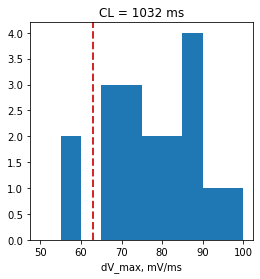

In [134]:
plt.figure(figsize=plt.figaspect(1))

plt.hist(dV_list, bins=list(range(50, 101, 5)))
plt.axvline(63, color='C3', ls='--', lw=2)

plt.xlabel('dV_max, mV/ms')
plt.title('CL = 1032 ms')
plt.savefig("./images/koivumaki/dV_max_voigt.png", dpi=300)

In [169]:
from datetime import datetime

# datetime object containing current date and time
now = datetime.now()
 
print("now =", now)

# dd/mm/YY H:M:S
dt_string = now.strftime("%y%m%d_%H%M%S")
print("date and time =", dt_string)	


now = 2020-12-02 22:57:51.774292
date and time = 201202_225751


In [178]:
os.makedirs("test", exist_ok=True)